# Features exploration

This notebook consists on some code for exploring the ECG dataset, according to features computed from the raw signals.

In [ ]:
# Clone the repository
!git clone https://[PERSONAL ACCESS TOKEN REMOVED HERE!!!]@github.com/sergi-andreu/Idoven-challenge.git

fatal: destination path 'Idoven-challenge' already exists and is not an empty directory.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Mount drive and import some required packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.fft import rfft, rfftfreq
import scipy.signal as sp

import seaborn as sb
import pandas as pd

## Load some ECG data

Here, the only the fold 2 is loaded. This is to reduce the computing time associated to the pairplot, mainly. The fold_idx can be changed to plot the results for different folds.

In [ ]:
drivepath = "drive/MyDrive/idoven"
fold_idx = 2
X = np.load(f"{drivepath}/nparrays/{str(fold_idx).zfill(2)}.npy")
Y = np.load(f"{drivepath}/nparrays/labels/{str(fold_idx).zfill(2)}.npy")

## Compute features from ECG data

The computed features, per channel, will be:
- *mean_abs*: The mean of the absolute value of the signal
- *std*: Standard deviation of the signal
- *gradnorm*: The mean of the absolute value of the gradient (finite derivative)
- *sc*: Spectral centroid [see wikipedia page](https://en.wikipedia.org/wiki/Spectral_centroid#:~:text=The%20spectral%20centroid%20is%20a,called%20center%20of%20spectral%20mass.)
- *sf*: Spectral flatness [see wikipedia page](https://en.wikipedia.org/wiki/Spectral_flatness#:~:text=Spectral%20flatness%20or%20tonality%20coefficient,opposed%20to%20being%20noise%2Dlike.).

This features have been selected arbitrarily, since I do not possess any domain knowledge of ECG data. Better features could be computed

In [ ]:
#Compute FFT for sc and sf
FFT = np.abs(rfft(X, axis=1))
freqs = rfftfreq(np.shape(X)[1])
mass = np.tensordot(FFT, freqs, ((1,), (0,)))
sc = mass / np.sum(FFT, axis=1)

sf = np.exp(np.sum(np.log(FFT), axis=1) / np.shape(FFT)[1]) / np.sum(FFT, axis=1)
del FFT, freqs, mass

"""
# Code for computing spectral bandwidth
# computed inefficiently memory-wise. therefore skipped

dummy_sc = np.expand_dims(sc, axis=1)
dummy_sc = np.repeat(dummy_sc, np.shape(freqs), axis=1)

dummy_freqs = np.expand_dims(sc, axis=1)
dummy_freqs = np.repeat(dummy_freqs, np.shape(dummy_sc)[1], axis=1)

diff = dummy_freqs - dummy_sc
diff = np.power(diff, 2)
mass_var = np.tensordot(FFT, diff, ((1,), (1,)))
print(np.shape(diff))
"""

# Computing means_abs, std and gradnorm
means_abs = np.mean(np.abs(X), axis=1)
std = np.std(X, axis=1)
gradnorm = np.mean(np.abs(np.gradient(X, axis=1)), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


### Load the mean heartbeat (computed in another notebook)

In [ ]:
BPM = np.load(f"{drivepath}/nparrays/bpm/{str(fold_idx).zfill(2)}.npy")

## Create the dataframe
Here we plot the dataframe per-channel. Set the "channel_idx" variable to the desired channel.
The pairplot presented here is with respect to the "normal" label (if the ECG data has been labelled as "NORM"). This can be changed by setting "Y[:,0]" to be other index. Plotting only the NORM-label pairplot for simplicity.

In [ ]:
channel_idx = 1
dataframe = pd.DataFrame(data=(means_abs[:,channel_idx], 
                         std[:,channel_idx], gradnorm[:,channel_idx], sc[:,channel_idx], 
                         sf[:,channel_idx], BPM[:,channel_idx], Y[:,0]))
dataframe = dataframe.transpose()
dataframe.columns =["means_abs", "std", "gradnorm", "Spectral Centroid", "Spectral Flatness", "BPM", "normal"]
dataframe["normal"] = dataframe["normal"].map({0.0 : "No", 1.0 : "Yes"})
print(dataframe["normal"].value_counts())

No     1214
Yes     967
Name: normal, dtype: int64


### Plot the pairplot

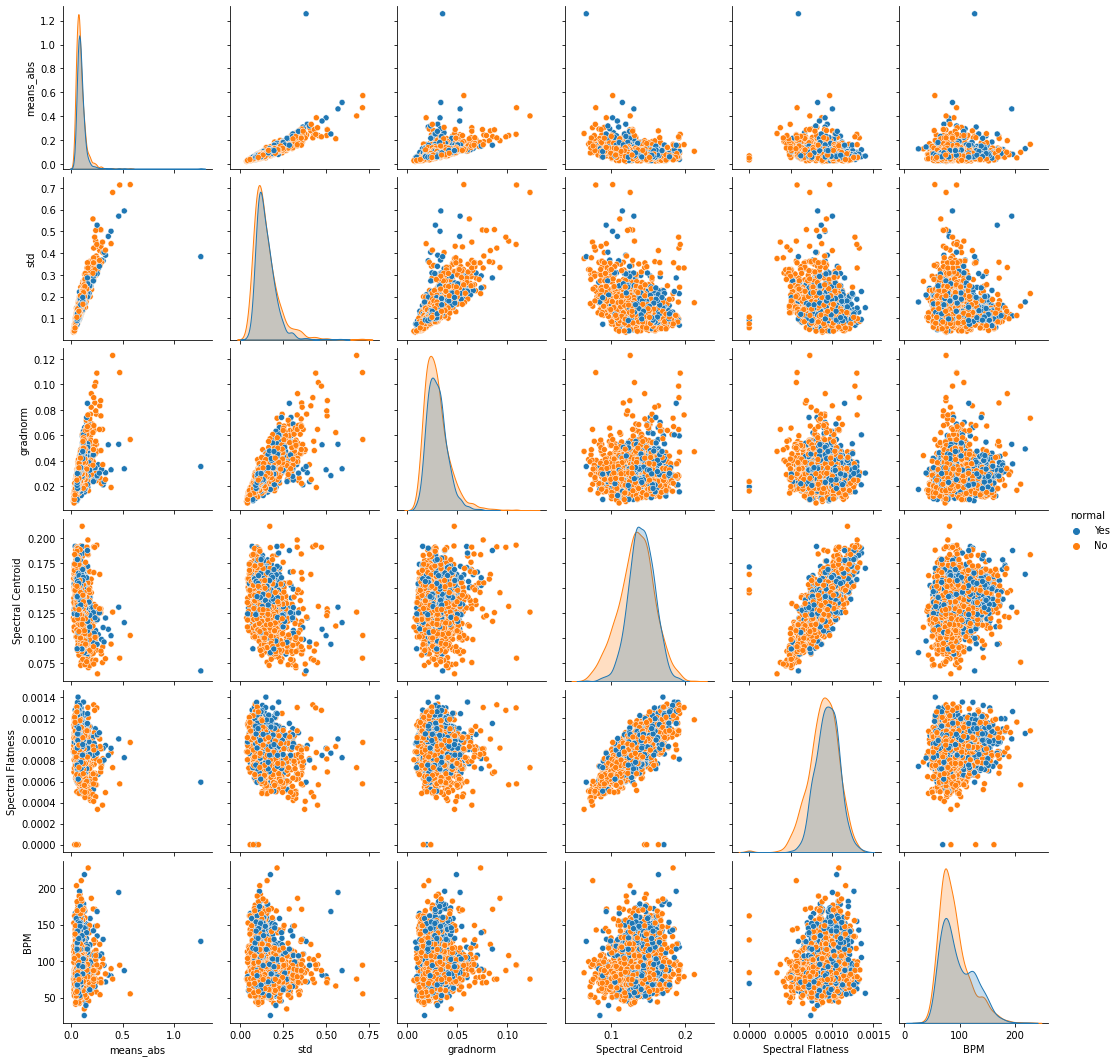

In [ ]:
dataframe["normal"]
sb.pairplot(dataframe, hue="normal")
plt.show()

## Train simple classifiers

First compute features for train and test data. (Functionalize previous code)

In [ ]:
from scipy.fft import rfft, rfftfreq

def compute_features(fold_idx):
  X = np.load(f"{drivepath}/nparrays/{str(fold_idx).zfill(2)}.npy")
  Y = np.load(f"{drivepath}/nparrays/labels/{str(fold_idx).zfill(2)}.npy")

  bpm = np.load(f"{drivepath}/nparrays/bpm/{str(fold_idx).zfill(2)}.npy")

  FFT = np.abs(rfft(X, axis=1))
  freqs = rfftfreq(np.shape(X)[1])
  mass = np.tensordot(FFT, freqs, ((1,), (0,)))
  sc = mass / np.sum(FFT, axis=1)
  
  sf = np.exp(np.sum(np.log(FFT), axis=1) / np.shape(FFT)[1]) / np.sum(FFT, axis=1)
  
  means_abs = np.mean(np.abs(X), axis=1)
  std = np.std(X, axis=1)
  gradnorm = np.mean(np.abs(np.gradient(X, axis=1)), axis=1)

  del X

  x_features = np.stack((means_abs, std, gradnorm, sf, sc, bpm))
  x_features = np.swapaxes(x_features, 0, 1)

  x_features = x_features.reshape(x_features.shape[0], x_features.shape[1]*x_features.shape[2])

  return x_features, Y

feat, y = compute_features(1)
print(np.shape(feat))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


(2175, 72)


Compute the features for the test fold (fold 10) and for the training data (folds 1 to 9)

In [ ]:
test_features, test_labels = compute_features(10)

# Save the training data in a dictionary to facilitate the k-fold training
all_features_dict = {}
all_labels_dict = {}
for i in range(1, 10):
  feat, y = compute_features(i)
  all_features_dict[i] = feat
  all_labels_dict[i] = y

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path

### Install sklearn-intelex to speed up training

In [ ]:
!pip install scikit-learn-intelex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Using Support Vector Machines

We here obtain results with SVM, with a linear kernel (or "no kernel").
Other possibilities are SVC with kernels (RBF, ...), KNeighbors Classifiers, Decision Tree, Random Forest, AdaBoost, ... or using other libraries such as XGBoost.

However, here we restrict to only SVM (classifiers) with linear kernels, for simplicitly. An extension of this code for the other classifiers is straight-forward.

In [ ]:
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report

import seaborn as sns

from sklearnex import patch_sklearn 
patch_sklearn()

imp = SimpleImputer(missing_values=np.nan, strategy='mean')

dict_names = {0 : "NORM", 1 : "MI", 2: "STTC", 3 : "CD", 4 : "HYP"}

def plot_classifiers_score(label_idx, balanced=False):

  print(f"Plots for {dict_names[label_idx]} label")

  cm_list = []

  y_true, y_pred = [], []

  for i in range(1, 10):
    test_data = imp.fit_transform(all_features_dict[i])
    test_labels = all_labels_dict[i][:,label_idx]

    for idx in range(1, 10):
      if idx != i:
        try: train_all = np.append(train_all, all_features_dict[idx], axis=0)
        except: train_all = all_features_dict[idx]

        try: train_labels_all = np.append(train_labels_all, all_labels_dict[idx], axis=0)
        except: train_labels_all = all_labels_dict[idx]
    
    train_data = imp.fit_transform(train_all)
    train_labels = train_labels_all[:,label_idx]

    del train_all, train_labels_all

    if balanced:
      n_samp = np.sum(train_labels) / len(train_labels)
      clf = svm.SVC(class_weight={0:1/(1-n_samp), 1:1/n_samp})
    else:
      clf = svm.SVC()
    clf.fit(train_data, train_labels)

    pred = clf.predict(test_data)

    cm = confusion_matrix(test_labels, pred, normalize="true")
    cm_list = cm_list + [cm]

    y_pred = y_pred + pred.tolist()
    y_true = y_true + test_labels.tolist()

  cm_mean = np.mean(cm_list, axis=0)
  cm_std = np.std(cm_list, axis=0)

  plt.yticks([1.5, 0.5], ['0', '1'], ha='right')
  plt.xticks([1.5, 0.5], ['0', '1'], ha='right')

  annotations = [["",""],["",""]]
  for row in range(2):
    for col in range(2):
      annotations[row][col] = f"{cm_mean[row][col]:.2f} +- {cm_std[row][col]:.2f} %"

  ax = sns.heatmap(cm_mean, annot=annotations, fmt = '')
  ax.set(xlabel='True Label', ylabel='Prediction Label')
  plt.savefig('reverse_tp_tn.png')
  plt.show()

  print(classification_report(y_true, y_pred, target_names=["Not present", "Present"]))

  return cm_list

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Computing the decisions with naive SVC
Compute the results without weigting the classes.
The classes are imbalanced (not that much for the NORM label), thus getting very bad results for the imbalanced labels (all the mass is put into the majority class).

Plots for NORM label


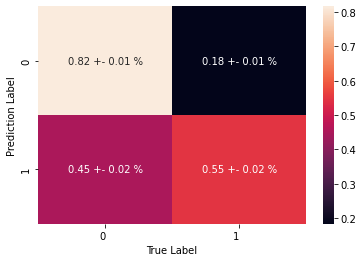

              precision    recall  f1-score   support

 Not present       0.70      0.82      0.75     11049
     Present       0.70      0.55      0.61      8554

    accuracy                           0.70     19603
   macro avg       0.70      0.68      0.68     19603
weighted avg       0.70      0.70      0.69     19603



In [ ]:
cm = plot_classifiers_score(0)

Plots for MI label


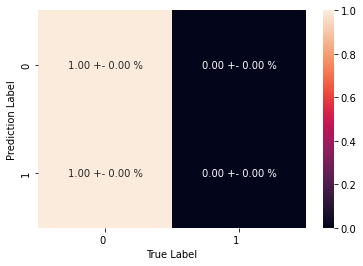

              precision    recall  f1-score   support

 Not present       0.75      1.00      0.86     14681
     Present       0.00      0.00      0.00      4922

    accuracy                           0.75     19603
   macro avg       0.37      0.50      0.43     19603
weighted avg       0.56      0.75      0.64     19603



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cm = plot_classifiers_score(1)

Plots for STTC label


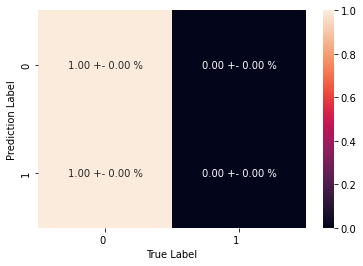

              precision    recall  f1-score   support

 Not present       0.76      1.00      0.86     14887
     Present       0.00      0.00      0.00      4716

    accuracy                           0.76     19603
   macro avg       0.38      0.50      0.43     19603
weighted avg       0.58      0.76      0.66     19603



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cm = plot_classifiers_score(2)

Plots for CD label


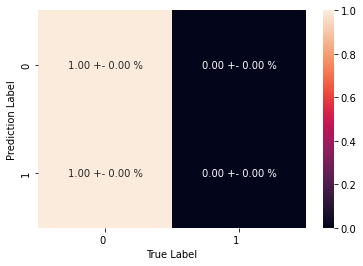

              precision    recall  f1-score   support

 Not present       0.78      1.00      0.87     15199
     Present       0.00      0.00      0.00      4404

    accuracy                           0.78     19603
   macro avg       0.39      0.50      0.44     19603
weighted avg       0.60      0.78      0.68     19603



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cm = plot_classifiers_score(3)

Plots for HYP label


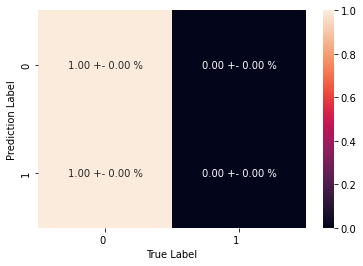

              precision    recall  f1-score   support

 Not present       0.88      1.00      0.94     17216
     Present       0.00      0.00      0.00      2387

    accuracy                           0.88     19603
   macro avg       0.44      0.50      0.47     19603
weighted avg       0.77      0.88      0.82     19603



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cm = plot_classifiers_score(4)

## Computing the decisions with weighted SVC
Setting a weight per-class corresponding to class frequency improves training

Plots for NORM label


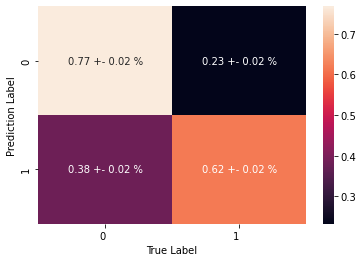

              precision    recall  f1-score   support

 Not present       0.72      0.77      0.74     11049
     Present       0.67      0.62      0.65      8554

    accuracy                           0.70     19603
   macro avg       0.70      0.69      0.69     19603
weighted avg       0.70      0.70      0.70     19603



In [ ]:
cm = plot_classifiers_score(0, balanced=True)

Plots for MI label


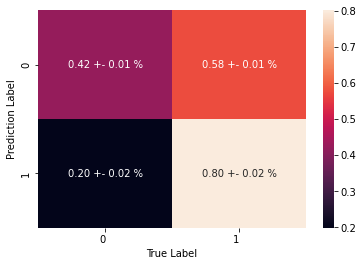

              precision    recall  f1-score   support

 Not present       0.86      0.42      0.57     14681
     Present       0.32      0.80      0.46      4922

    accuracy                           0.52     19603
   macro avg       0.59      0.61      0.51     19603
weighted avg       0.73      0.52      0.54     19603



In [ ]:
cm = plot_classifiers_score(1, balanced=True)

Plots for STTC label


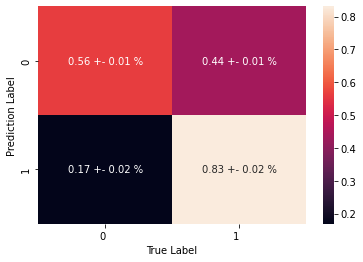

              precision    recall  f1-score   support

 Not present       0.91      0.56      0.70     14887
     Present       0.38      0.83      0.52      4716

    accuracy                           0.63     19603
   macro avg       0.64      0.70      0.61     19603
weighted avg       0.78      0.63      0.65     19603



In [ ]:
cm = plot_classifiers_score(2, balanced=True)

Plots for CD label


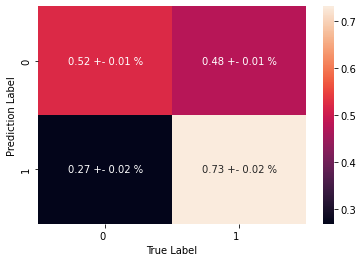

              precision    recall  f1-score   support

 Not present       0.87      0.52      0.65     15199
     Present       0.31      0.73      0.43      4404

    accuracy                           0.57     19603
   macro avg       0.59      0.63      0.54     19603
weighted avg       0.74      0.57      0.60     19603



In [ ]:
cm = plot_classifiers_score(3, balanced=True)

Plots for HYP label


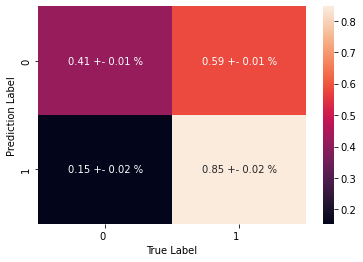

              precision    recall  f1-score   support

 Not present       0.95      0.41      0.58     17216
     Present       0.17      0.85      0.28      2387

    accuracy                           0.47     19603
   macro avg       0.56      0.63      0.43     19603
weighted avg       0.86      0.47      0.54     19603



In [ ]:
cm = plot_classifiers_score(4, balanced=True)